In [33]:
import numpy as np
import cv2
import logging
from argparse import ArgumentParser
import sys
sys.path.append('/mnt/c/Users/niran/Documents/personal_work/fun_projects/fortune_telling_with_rpi/py_env/lib/python3.10/site-packages')
sys.path.append('/home/friday/fortune_telling_with_rpi/mmpose')
from mmcv.image import imread
from mmengine.logging import print_log

from mmpose.apis import inference_topdown, init_model
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples
import matplotlib.pyplot as plt

Loads checkpoint by local backend from path: /home/friday/fortune_telling_with_rpi/data/models/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


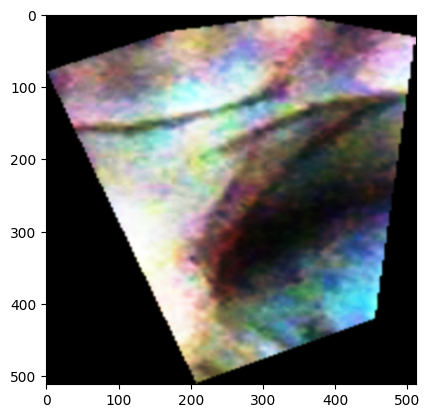

In [44]:
# params
config_path = '/home/friday/fortune_telling_with_rpi/mmpose/configs/hand_2d_keypoint/rtmpose/hand5/rtmpose-m_8xb256-210e_hand5-256x256.py'
checkpoint = "/home/friday/fortune_telling_with_rpi/data/models/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth"
# rtmpose-m_simcc-coco-wholebody-hand_pt-aic-coco_210e-256x256-99477206_20230228.pth"

thickness = 1
radius = 3
alpha = 0.8
skeleton_style = 'mmpose'
kpt_thr = 0.3
draw_heatmap = False
show_kpt_idx = False
show = False
out_file = "./test.bmp"

img_path = "/home/friday/fortune_telling_with_rpi/data/rpi_data/images/image_9.jpeg"


def model_building(config_path: str, checkpoint: str):
    model = init_model(
        config_path,
        checkpoint,
        device='cpu')

    model.cfg.visualizer.radius = radius
    model.cfg.visualizer.alpha = alpha
    model.cfg.visualizer.line_width = thickness
    return model


def inference_model(model, img_path: str):
    batch_results = inference_topdown(model, img_path)
    results = merge_data_samples(batch_results)
    return results

def get_palm_img(results, img):
    # the points are
    # 0 -> wrist
    # 1 -> thumb1
    # 5 -> forefinger1
    # 9 -> middlefinger1
    # 13 -> ringfinger1
    # 17 -> pinky1
    key_points_detected = results.pred_instances.keypoints[0]
    points_to_select = [0, 1, 5, 9, 13, 17]
    # Extract points for contour
    selected_points = key_points_detected[points_to_select]
    # Convert points to integer coordinates for contour
    contour_points = selected_points.astype(np.int32)
    
    # Create mask from contour
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [contour_points], 255)

    # Apply mask to image
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    # Get bounding box of contour
    x,y,w,h = cv2.boundingRect(contour_points)

    # Crop image to bounding box
    cropped = masked_img[y:y+h, x:x+w]

    # Resize to 256x256
    resized = cv2.resize(cropped, (512, 512))
    
    b, g, r = cv2.split(resized)
    b = cv2.equalizeHist(b)
    b = cv2.GaussianBlur(b, (5,5), 0)
    g = cv2.equalizeHist(g)
    g = cv2.GaussianBlur(g, (5,5), 0)
    r = cv2.equalizeHist(r)
    r = cv2.GaussianBlur(r, (5,5), 0)
    # Merge channels back together
    resized = cv2.merge((b, g, r))
    
    
    return resized

def show_pose_prediction(results, img_path, model, out_file: str):
    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.set_dataset_meta(
    model.dataset_meta, skeleton_style=skeleton_style)
    visualizer.add_datasample(
        'result',
        img_path,
        data_sample=results,
        draw_gt=False,
        draw_bbox=True,
        kpt_thr=kpt_thr,
        draw_heatmap=draw_heatmap,
        show_kpt_idx=show_kpt_idx,
        skeleton_style=skeleton_style,
        show=show,
        out_file=out_file)

img = imread(img_path, channel_order='rgb')
model = model_building(config_path, checkpoint)
results = inference_model(model, img_path)
palm_img = get_palm_img(results, img)
plt.imshow(palm_img)
# show_pose_prediction(results, img, model, out_file)
